In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from importlib import reload  
import helper as h
reload(h)
import helper as h

In [2]:
#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
library(scran)
library(BiocParallel)

In [4]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'

In [ ]:
adata_rn=sc.read(path_data+'data_rawnorm_integrated_annotated.h5ad')

In [5]:
adata=sc.read(path_data+'data_integrated_analysed.h5ad')

In [5]:
# Add obs info to rn data
adata_rn.obs=adata.obs.copy()
# log-Normalised n_counts
adata_rn.obs['n_counts_log_norm']=adata_rn.X.sum(axis=1)

In [40]:
ct_col='cell_type_integrated_v1'

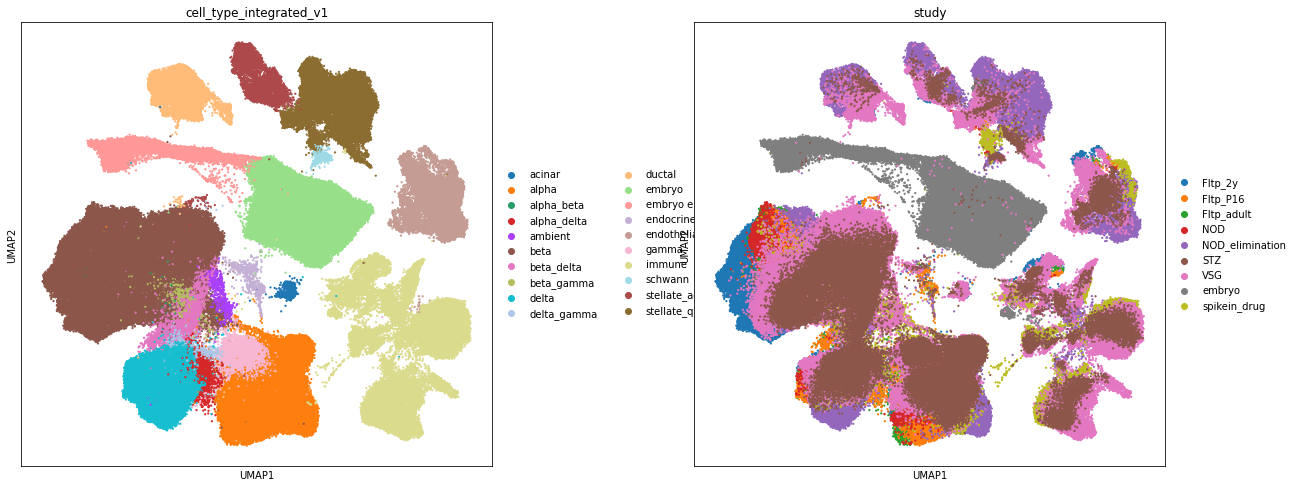

In [45]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata,color=[ct_col,'study'],s=20,wspace=0.3)

## Counts distn across cell types and samples

Heatmap of n_counts (based on log-transformed normalised expression - normalisation per sample) as a mean across cell types of each sample.

In [29]:
# Counts DF for heatmap
counts_norm=[]
studies=[]
for study in adata.obs.study.unique():
    for sample in adata.obs.query('study==@study').file.unique():
        obs_sub=adata_rn.obs.query('study==@study & file==@sample')
        counts_norm_sample=obs_sub.groupby(ct_col)['n_counts_log_norm'].mean()
        counts_norm_sample.name=study+'_'+sample
        counts_norm.append(counts_norm_sample)
        studies.append(study)

counts_norm=pd.concat(counts_norm,axis=1)
counts_norm.fillna(0,inplace=True)

In [30]:
# Heatma anno
study_cmap=dict(zip(adata.obs.study.cat.categories,adata.uns['study_colors']))
ct_cmap=dict(zip(adata.obs[ct_col].cat.categories,adata.uns[ct_col+'_colors']))
row_anno=pd.Series(counts_norm.index.map(ct_cmap),index=counts_norm.index,name='cell type')
col_anno=pd.Series([study_cmap[study] for study in studies],
                   index=counts_norm.columns,name='study')

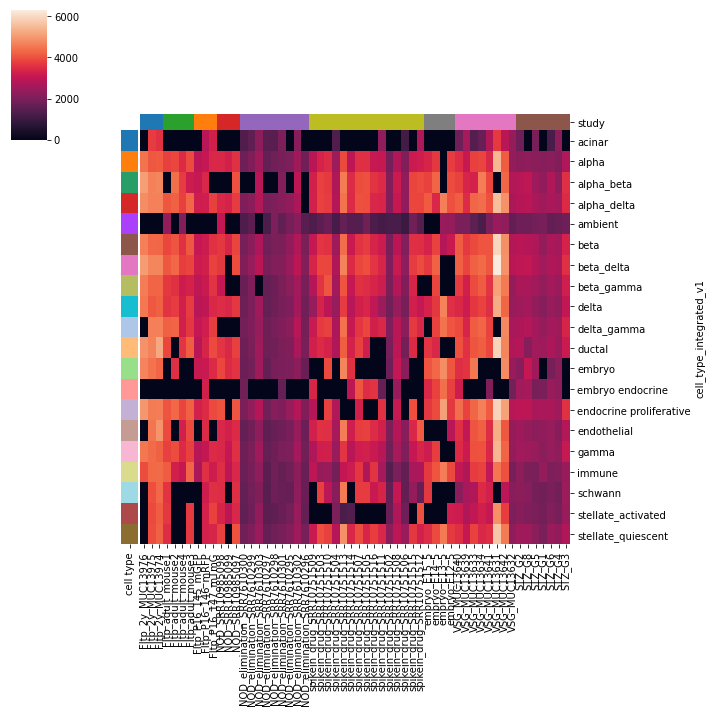

In [31]:
sb.clustermap(counts_norm,xticklabels=True,yticklabels=True, 
              row_cluster=False,col_cluster=False,
              row_colors=row_anno,col_colors=col_anno)

C: It seems that some studies/samples have much higher n_counts in log-transformed normalised data than others.

## Integrated cl based size factors
Since size factors from per-sample data are biased redo normalisation on integrated clusters.

In [6]:
scran_groups='leiden_r2'

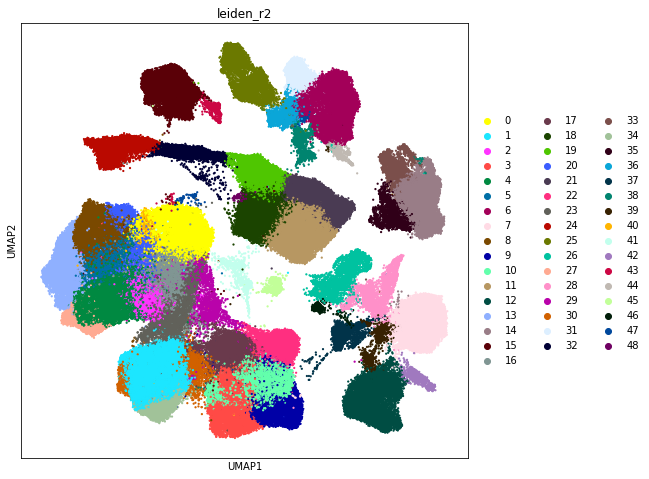

In [51]:
sc.pl.umap(adata,color=scran_groups,s=20)

In [7]:
# Preprocess variables for scran normalization

# Scran groups
input_groups = adata.obs[scran_groups]

# get raw data
adata_raw=adata.raw.to_adata()
# Base normalisation of genes present in integrated datasets (e.g. expressed, filtered top ambient)
adata_raw=adata_raw[:,adata.var_names]
print('Adata raw:',adata_raw.shape)
# Transpose and convert to dense for scran
data_mat=adata_raw.X.T.todense()
del adata_raw
print('Data mat:',data_mat.shape)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Adata raw: (301796, 13999)
Data mat: (13999, 301796)


In [8]:
%%R -i data_mat -i input_groups -o size_factors
size_factors =  calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1,
                                    BPPARAM=MulticoreParam(workers = 20))

In [9]:
# Add sf to adata
adata.obs['size_factors_integrated'] = size_factors

Compare size factors to n_genes and n_counts computed on data_mat

In [24]:
data_mat.sum(axis=0).reshape(-1,1).shape

(1, 301796)

In [25]:
# Add n counts and n genes info to adata for plotting
adata.obs['n_counts']=data_mat.sum(axis=0).reshape(-1,1)
adata.obs['n_genes']=(data_mat>0).sum(axis=0).reshape(-1,1)

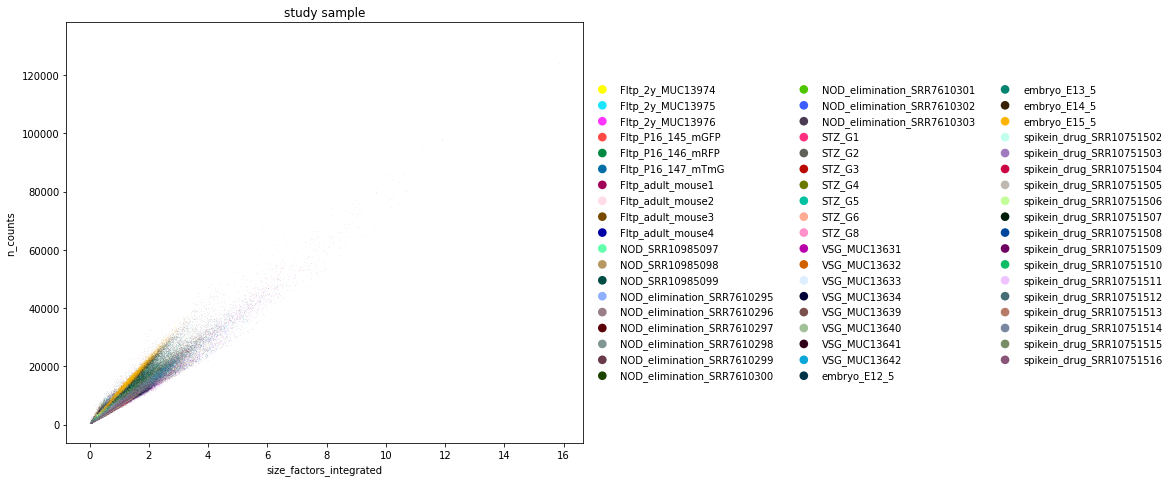

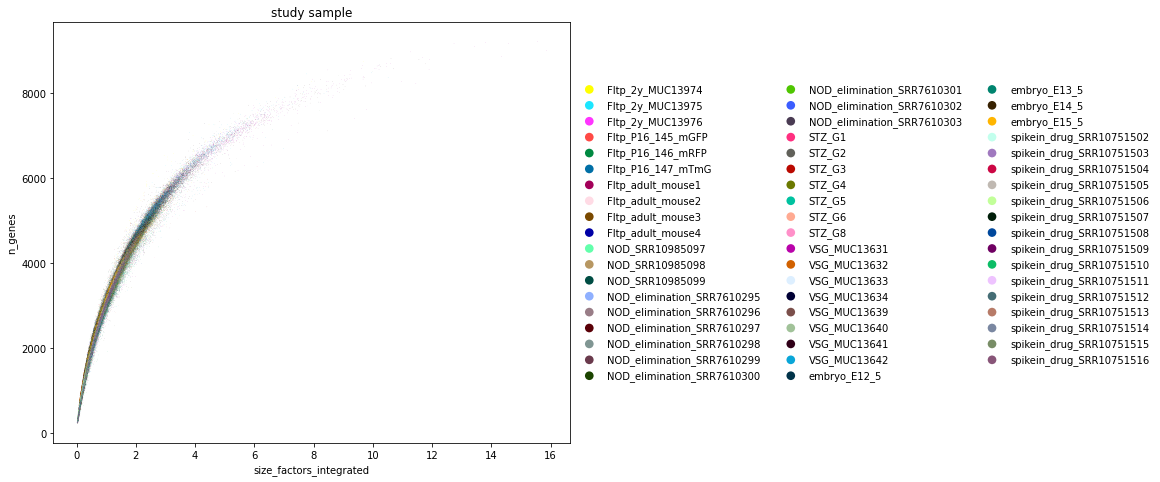

In [27]:
# SF by sample
rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors_integrated', 'n_counts', color='study_sample')
sc.pl.scatter(adata, 'size_factors_integrated', 'n_genes', color='study_sample')

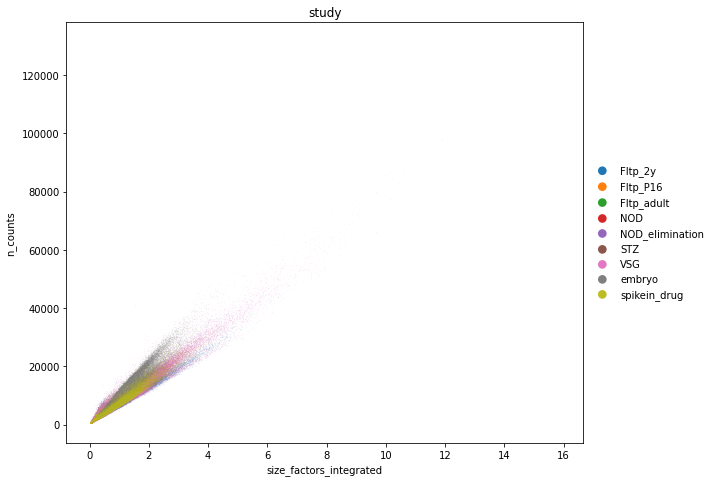

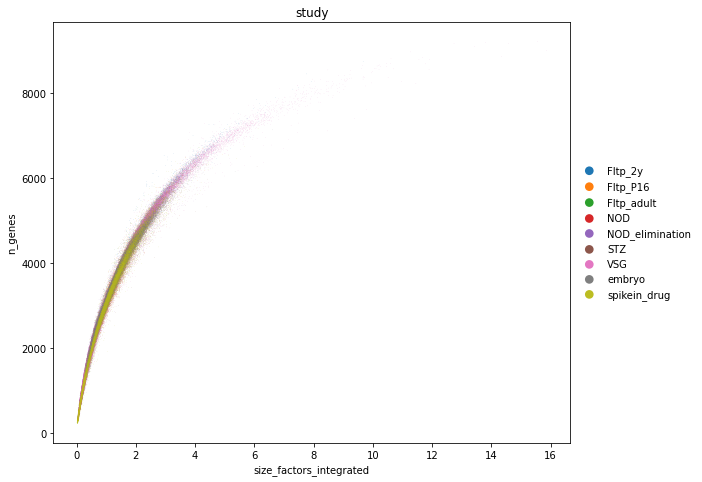

In [28]:
# SF by study
rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors_integrated', 'n_counts', color='study')
sc.pl.scatter(adata, 'size_factors_integrated', 'n_genes', color='study')

C: Embryo has a bit different size-factor to n_counts distn compared to other studies. This is likely due to different cell types present in embryo.

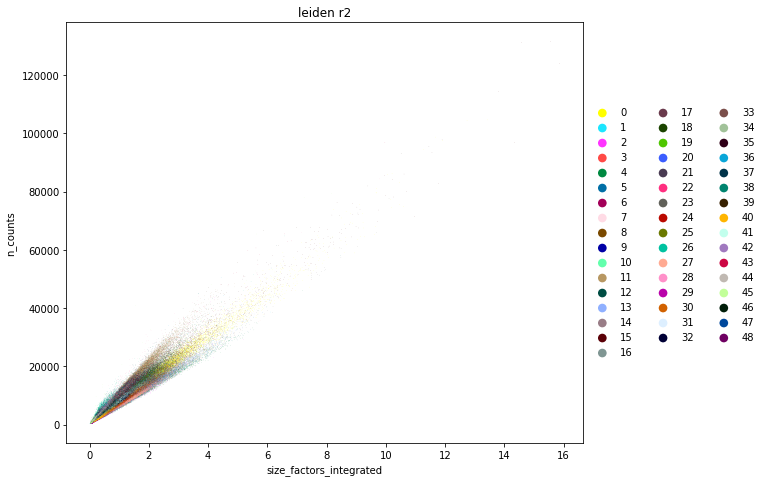

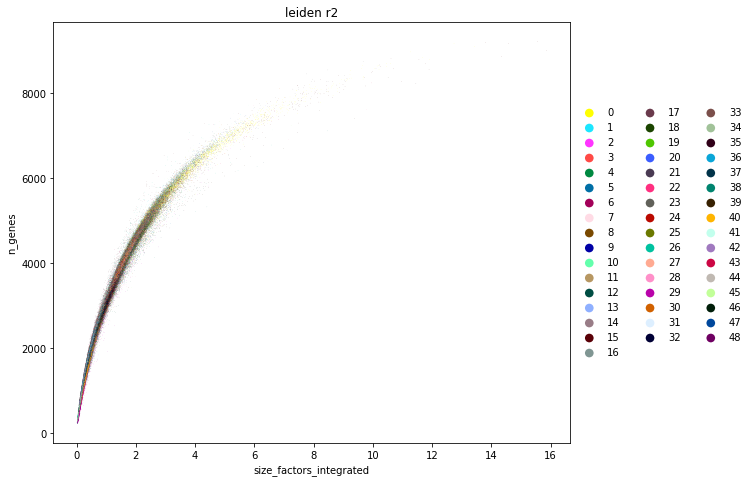

In [29]:
#let us visualise how size factors differ across clusters
rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors_integrated', 'n_counts', color=scran_groups)
sc.pl.scatter(adata, 'size_factors_integrated', 'n_genes', color=scran_groups)

Distribution of size factors


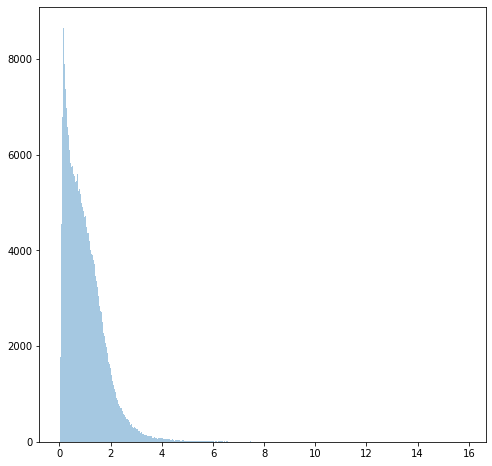

In [32]:
print('Distribution of size factors')
sb.distplot(size_factors, bins=500, kde=False)
plt.show()

#### Save size factors

In [35]:
h.update_adata(adata_new=adata,path=path_data+'data_integrated_analysed.h5ad',
               add=[('obs',True,'size_factors_integrated','size_factors_integrated')],
               rm=None,unique_id2=None,io_copy=False)

In [25]:
h.update_adata(adata_new=adata,path=path_data+'data_rawnorm_integrated_annotated.h5ad',
               add=[('obs',True,'size_factors_integrated','size_factors_integrated')],
               rm=None,unique_id2=None,io_copy=False)

### New expression counts per cell type and sample

In [ ]:
adata_rn2=h.get_rawnormalised(adata,sf_col='size_factors_integrated',use_log=True)

In [38]:
adata_rn2.obs['n_counts_log_norm']=adata_rn2.X.sum(axis=1)

In [42]:
# Counts DF for heatmap
counts_norm=[]
studies=[]
for study in adata.obs.study.unique():
    for sample in adata.obs.query('study==@study').file.unique():
        obs_sub=adata_rn2.obs.query('study==@study & file==@sample')
        counts_norm_sample=obs_sub.groupby(ct_col)['n_counts_log_norm'].mean()
        counts_norm_sample.name=study+'_'+sample
        counts_norm.append(counts_norm_sample)
        studies.append(study)

counts_norm=pd.concat(counts_norm,axis=1)
counts_norm.fillna(0,inplace=True)

In [46]:
# Heatma anno
study_cmap=dict(zip(adata.obs.study.cat.categories,adata.uns['study_colors']))
ct_cmap=dict(zip(adata.obs[ct_col].cat.categories,adata.uns[ct_col+'_colors']))
row_anno=pd.Series(counts_norm.index.map(ct_cmap),index=counts_norm.index,name='cell type')
col_anno=pd.Series([study_cmap[study] for study in studies],
                   index=counts_norm.columns,name='study')

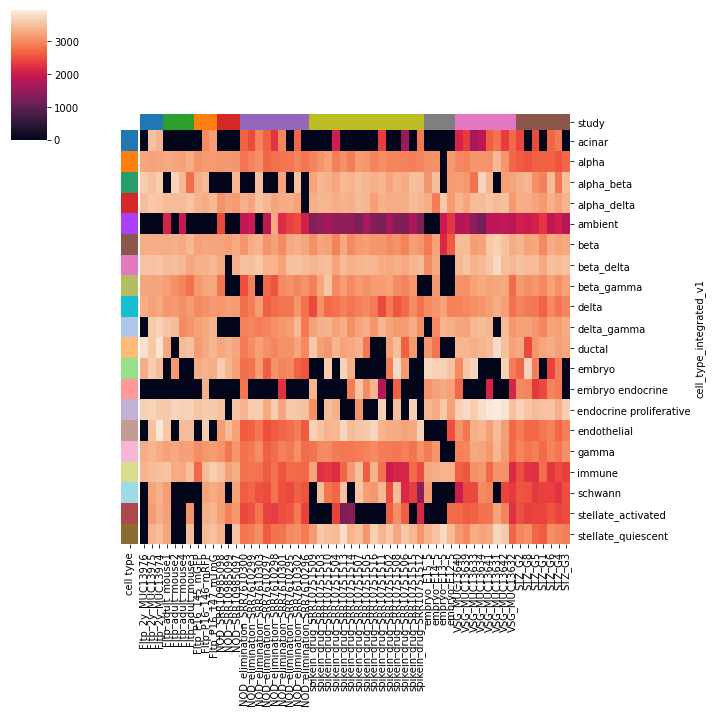

In [47]:
sb.clustermap(counts_norm,xticklabels=True,yticklabels=True, 
              row_cluster=False,col_cluster=False,
              row_colors=row_anno,col_colors=col_anno)

Do the same on clusters

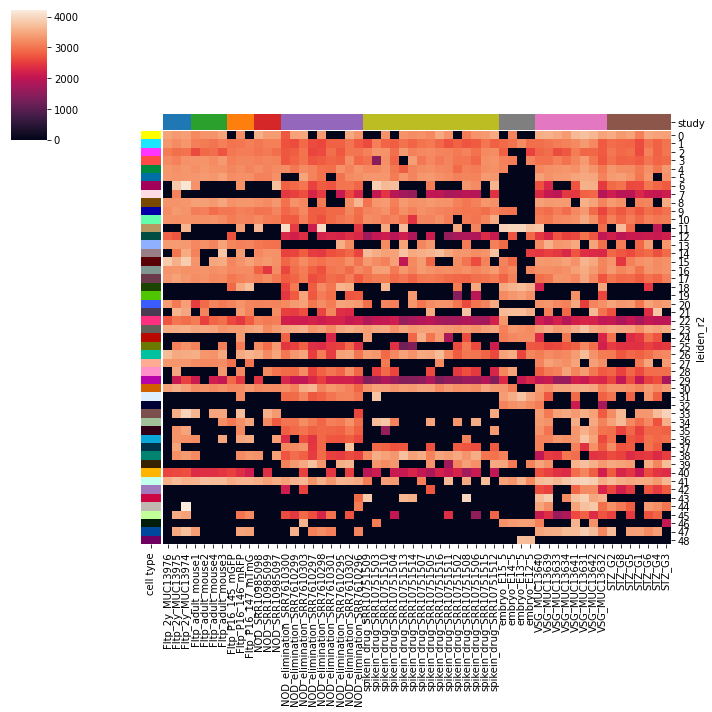

In [48]:
# Counts DF for heatmap
ct_col2='leiden_r2'
counts_norm=[]
studies=[]
for study in adata.obs.study.unique():
    for sample in adata.obs.query('study==@study').file.unique():
        obs_sub=adata_rn2.obs.query('study==@study & file==@sample')
        counts_norm_sample=obs_sub.groupby(ct_col2)['n_counts_log_norm'].mean()
        counts_norm_sample.name=study+'_'+sample
        counts_norm.append(counts_norm_sample)
        studies.append(study)

counts_norm=pd.concat(counts_norm,axis=1)
counts_norm.fillna(0,inplace=True)

# Heatma anno
study_cmap=dict(zip(adata.obs.study.cat.categories,adata.uns['study_colors']))
ct_cmap=dict(zip(adata.obs[ct_col2].cat.categories,adata.uns[ct_col2+'_colors']))
row_anno=pd.Series(counts_norm.index.map(ct_cmap),index=counts_norm.index,name='cell type')
col_anno=pd.Series([study_cmap[study] for study in studies],
                   index=counts_norm.columns,name='study')

sb.clustermap(counts_norm,xticklabels=True,yticklabels=True, 
              row_cluster=False,col_cluster=False,
              row_colors=row_anno,col_colors=col_anno)

C: Now there is more variation across cell types rather than samples/studies.

#### Save differently normalised layer in rawnormalised

In [54]:
adata_rn2.layers['X_sf_integrated']=adata_rn2.X
adata_rn2

AnnData object with n_obs × n_vars = 301796 × 30672
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'leiden_r0.4', 'design', 'cell_type_integrated', 'cell_type_integrated_v1', 'leiden_r1', 'leiden_r1.5', 'leiden_r2', 'leiden_r0.5', 'size_factors_integrated', 'n_counts', 'n_genes', 'n_counts_log_norm'
    var: 'gene_symbol', 'gene_symbol_original_matched'
    uns: 'cell_type_integrated_colors', 'cell_type_multiplet_colors', 'leiden', 'neighbors', 'pre_cell_type_colors', 'umap', 'study_sample_colors', 'study_colors', 'leiden_r2_colors', 'log1p'
    obsm: 'X_integrate

In [55]:
h.update_adata(adata_new=adata_rn2,path=path_data+'data_rawnorm_integrated_annotated.h5ad',
               add=[('layers',True,'X_sf_integrated','X_sf_integrated')],
               rm=None,unique_id2=None,io_copy=False)

## Add to beta data

In [5]:
# Load current rn beta data
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1.h5ad')

In [8]:
# Load data that has size factors
adata=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r')

In [9]:
# Make new beta data object
adata_rn_b_isf=adata_rn_b.copy()
adata_rn_b_isf.X=adata_rn[adata_rn_b_isf.obs_names,:].layers['X_sf_integrated']
adata_rn_b_isf.obs['size_factors_integrated']=adata[adata_rn_b_isf.obs_names,
                                                       :].obs['size_factors_integrated']

In [23]:
adata_rn_b_isf

AnnData object with n_obs × n_vars = 102143 × 30672
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'design', 'cell_type_integrated', 'cell_type_integrated_v1', 'gcg_score_scaled', 'ins_score_scaled', 'ppy_score_scaled', 'sst_score_scaled', 'n_counts', 'n_genes', 'mt_frac', 'emptyDrops_LogProb', 'emptyDrops_LogProb_scaled', 'leiden_r0.4', 'leiden_r0.7', 'leiden_r1', 'leiden_r1.5', 'leiden_r2', 'size_factors_integrated'
    var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_integrated', 'X_umap'

In [24]:
# Save new beta data object
adata_rn_b_isf.write(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')